## Minimal Example
### for "Explainable few-shot learning for identification of melanoma stage-associated skin tissue patterns in multi-antigen imaging data"
#### Anna Möller

We cannot provide our real data without any restrictions. Therefore, this tutorial uses simulated expression data. For the sake of simplicity, we generate a multi-antigen image with only three channels. However, this approach works with any reasonable number of channels.
Given the segmentation result  with uniquely labelled cells, the expression of the 3 antigens within these cells, and the multi-antigen image, we show how to use our code to extract regions of interest and conduct the analyses shown in our work.

Please make sure to install the conda environment specified in the environment.yml and clone the [THEORETIC repository](https://github.com/bionetslab/THEORETIC/). Unzip the hpa reference data for use with other data than the provided playground data.

____
Necessary imports:

In [1]:
import cv2 
import numpy as np
import pandas as pd
import anndata as ad
import sys
import matplotlib.pyplot as plt
import torchvision as tv
import torch as t
import seaborn as sns

sys.path.append("..")
from src import *

___
The segmentation file contains uniquely labelled cells.

In [2]:
segmentation = np.load("data/segmentation_mask.npy")
np.unique(segmentation)

array([   0,    1,    2, ..., 3305, 3306, 3307])

The expression matrix needs to contain these ids as indices and single-cell expression of the markers of interest.

In [3]:
expression = ad.read_h5ad("data/playground_expression_data.h5ad")
expression.var_names

Index(['MLANA', 'CD3G', 'CD14'], dtype='object')

In [4]:
expression

AnnData object with n_obs × n_vars = 3307 × 3

The multi-antigen image consists of one channel per antigen. In our simulated data, we map the expression to the segmentation mask and as we only have three channels, we can display all of them at once with RGB color coding. With our real data, the multi-antigen image exists first, and segmentation and expression are inferred from that. The original marker images obviously sometimes have signal that does not perfectly lie within the segmentation mask, and the intensities are not equal across all pixels within one cell.

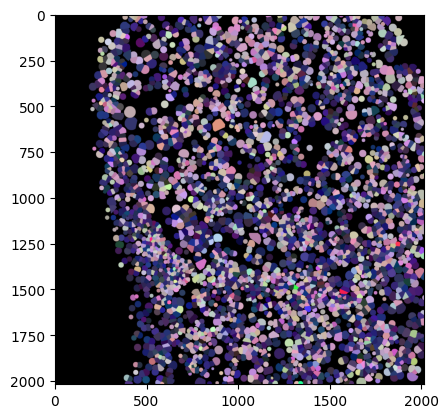

In [5]:
playground_sample = cv2.imread("data/playground_sample.png")
plt.imshow(playground_sample)

___
The reference data contains normalized expression of the markers in the different cell types.

In [6]:
try:
    reference = pd.read_csv("data/playground_reference.csv", index_col="Unnamed: 0")
except:
    reference = get_hpa_reference('skin')
    usable_genes = [c for c in reference.columns if c in expression.var_names]
    reference = reference[usable_genes]

In [7]:
reference

,MLANA,CD3G,CD14
Melanocytes,2387.8,1.7,5.2
T-cells,6.3,268.5,3.9
Macrophages,8.9,5.6,493.6


___
We start by identifying cell types using the expression data and the reference data. The min_fold_change and z_score_cutoff parameters can be adapted for more control on choosing which markers are characteristic from the reference data and which marker follows a bimodal distribution in the sample. The cell types are added to the expression anndata file. 

In [8]:
tree = identify_cell_types(expression, reference.copy(), min_fold_change=2, z_score_cutoff=1.)

In [9]:
for j, st in enumerate(tree.split_tuples): 
    print(st.cell_type, st.mapped_genes[0])

Melanocytes MLANA
Macrophages CD14


In [10]:
np.unique(expression.obs["cell_type"])

array(['Macrophages', 'Melanocytes', 'T-cells'], dtype=object)

___
We would normally use a model, which is trained for a task on the data for which we want to extract the regions of interest. As we cannot publicly provide the final weights for privacy reasons, we use the model downloaded from PyTorch, only pre-trained on ImageNet, for this tutorial. Any model architecture can be used for this purpose, however, it needs to provide a function "get_last_conv_activation" that returns the activation of the last convolutional layer. Please have a look at src/model/model.py for examples.

In [11]:
model = EfficientnetWithFinetuning(indim=len(expression.var_names), cam=True)

___
The input image is resized and normalized to fit the input dimensions. 

In [12]:
size = 512
resize_and_normalize = tv.transforms.Compose([
    tv.transforms.Resize((size, size), interpolation=tv.transforms.InterpolationMode.BILINEAR, antialias=True),
    tv.transforms.Normalize(mean=playground_sample.mean(axis=(0,1)), std=playground_sample.std(axis=(0,1)))
    ])

In [13]:
input_tensor = resize_and_normalize(t.tensor(playground_sample.transpose(2, 0, 1)).float())

___
The model outputs the prediction of the binary classification label being y=1.

In [14]:
print(model(input_tensor.unsqueeze(0)))

tensor([[0.6592]], grad_fn=<SigmoidBackward0>)


___
SmoothGrad uses the target label - in this case we use y=1 - and calculates, which image regions have been important to its decision. We add the information whether a cell is in a ROI to the anndata file.

In [15]:
target_label = 1.0
smooth_grad = get_smooth_grad([(input_tensor.unsqueeze(0), target_label)], model, n_smooth=10, cuda=False)

In [16]:
binary, ids = get_binary(smooth_grad, segmentation)
roi_info = np.zeros(expression.shape[0])
roi_info[ids[1:] - 1] = 1
expression.obs['in_roi'] = roi_info

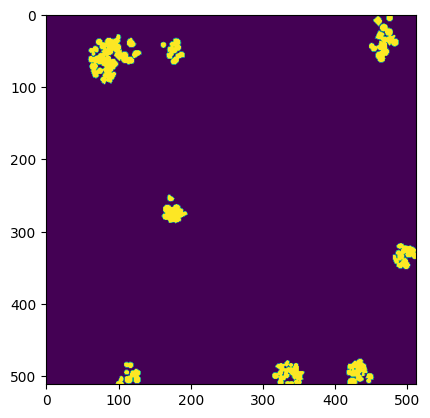

In [17]:
plt.imshow(binary)

___
The spatial mapping, the cell types, the ROI info, and the gene expression data allows numerous possibilities to analyze the data. Below, we show some examples.

In [18]:
df = expression.to_df()
df["cell_type"] = expression.obs["cell_type"]
df["in_roi"] = expression.obs["in_roi"].astype(bool)

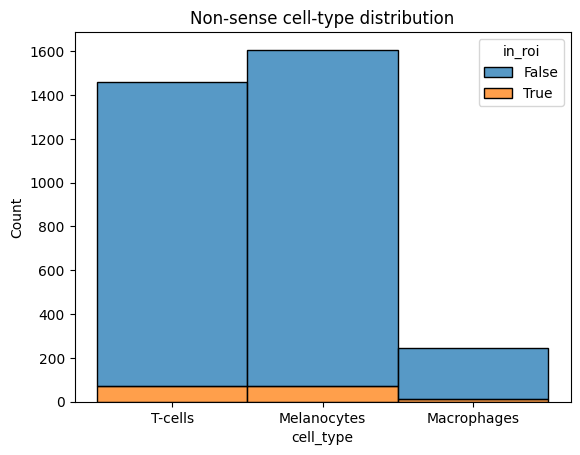

In [19]:
plt.title("Non-sense cell-type distribution")
sns.histplot(df, x="cell_type", hue="in_roi", multiple="stack")
plt.show()

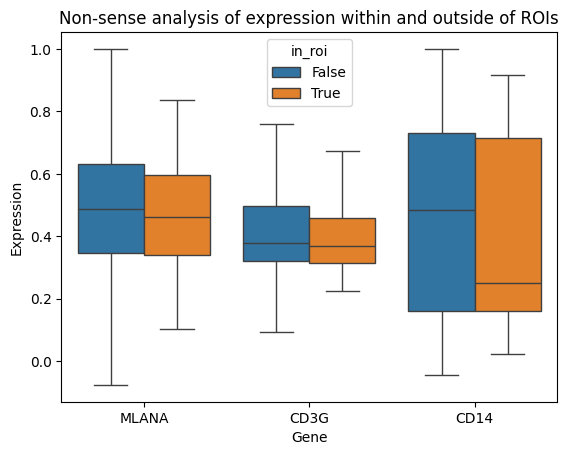

In [20]:
melted = pd.melt(df, id_vars=["in_roi", "cell_type"])
melted.rename({"variable": "Gene", "value": "Expression"}, inplace=True, axis=1)
sns.boxplot(melted, x="Gene", y="Expression", hue="in_roi", showfliers=False)
plt.title("Non-sense analysis of expression within and outside of ROIs")
plt.show()

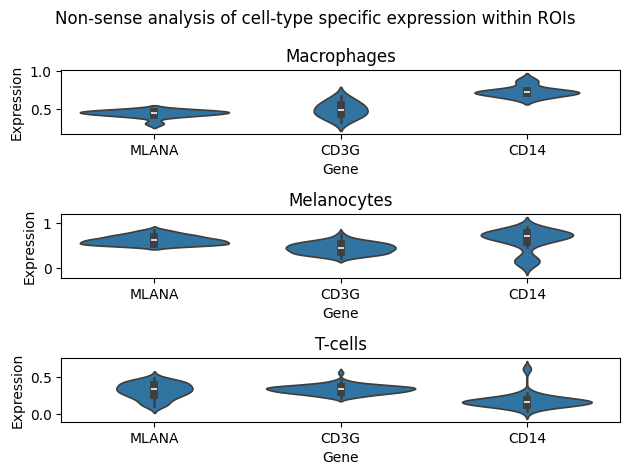

In [21]:
cell_types = np.unique(np.unique(expression.obs["cell_type"]))
f, axs = plt.subplots(len(cell_types))
for i, ct in enumerate(cell_types):
    subset = melted[(melted["in_roi"] == True) & (melted["cell_type"] == ct)]
    sns.violinplot(subset, x="Gene", y="Expression", ax=axs[i])
    axs[i].set_title(ct)
plt.suptitle("Non-sense analysis of cell-type specific expression within ROIs")
plt.tight_layout()
plt.show()